# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot, FontLibraryClass
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator, AbstractPropagator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator, Mask
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy
import pandas
from copy import deepcopy
from itertools import product
from typing import Iterable, Callable, Union
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (11.7, 16.5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров экспериметна

In [5]:
# Предпочтительные параметры
size = 9.765625E-6/2
near_N = 2048 #2004 #1336
near_length = 10.0E-3
wavelength = 500.0E-9
masks_amount = 1

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 40

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 

# Параметры эксперимента
hole_length = 2.5E-3
hole_distance_a = 400.0E-3
hole_distance_b_max = 400.0E-3
light_source_size = 0.05E-03
cols = 6
rows = 5
hole_distance_b_array = numpy.linspace(0, hole_distance_b_max+hole_distance_a, cols*rows)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       2048
Количество пикселей маски:                2048
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     4.883 мкм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    40


# Инициализация модулей

In [6]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
encoder, decoder = incoherent.encoder, incoherent.decoder

propagation_a = FurrierPropagation(N, length, wavelength, 1.0, 0.0, hole_distance_a, border_ratio=0.1)
propagation_b = FurrierPropagation(N, length, wavelength, 1.0, 0.0, hole_distance_b_max, border_ratio=0.1)

mask = Mask(N, length)
mask_filter = Window(centers=(0,0), sizes=(hole_length, hole_length))
mask.buffer = mask_filter(*[torch.linspace(-length/2,+length/2,N)]*2)

coherent_model = CompositeModel(propagation_a, mask, propagation_b).to(device)
incoherent_model = CompositeModel(encoder, propagation_a, mask, propagation_b, decoder).to(device)

source_filter = Gaussian(sigmas=[light_source_size/2]*2, means=(0,0))
source_filter = Window(centers=(0,0),sizes=(light_source_size,light_source_size))
source_field = source_filter(*[torch.linspace(-length/2,+length/2,N)]*2).unsqueeze(0).unsqueeze(0).to(device)

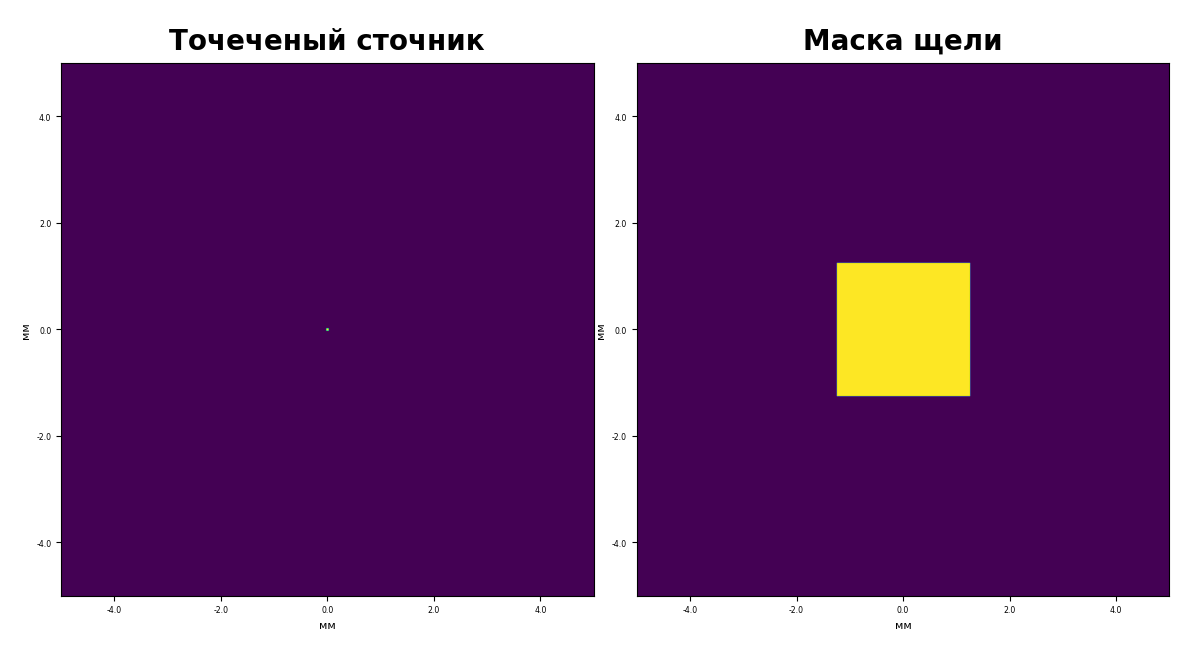

In [7]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
xy_formatter, xy_unit = engineering.separatedformatter(length, 'м')

axes = plot.axes.add(0,0)
axes.imshow(source_field[0,0].cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(xy_formatter)
axes.yaxis.set_major_formatter(xy_formatter)
plot.graph.label.x(xy_unit)
plot.graph.label.y(xy_unit)
plot.graph.title("Точеченый сточник")

axes = plot.axes.add(1,0)
axes.imshow(mask.buffer.cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(xy_formatter)
axes.yaxis.set_major_formatter(xy_formatter)
plot.graph.label.x(xy_unit)
plot.graph.label.y(xy_unit)
plot.graph.title("Маска щели")

plot.show()

# Вычисление

In [8]:
incoherent_results = []
coherent_results = []
with torch.no_grad():
    for distance, (col,row) in tqdm(zip(hole_distance_b_array, product(range(cols),range(rows))), total=cols*rows):
        propagation_b.distance = distance
        coherent_result = (coherent_model.forward(source_field).abs()**2).squeeze().cpu()
        incoherent_result = incoherent_model.forward(source_field).abs().squeeze().cpu()
        # coherent_result = coherent_model.forward(source_field, distance=distance).angle().squeeze().cpu()
        # incoherent_result = incoherent_model.forward(source_field, distance=distance).angle().squeeze().cpu()
        incoherent_results.append(incoherent_result)
        coherent_results.append(coherent_result)

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.12it/s]


# Отрисовка

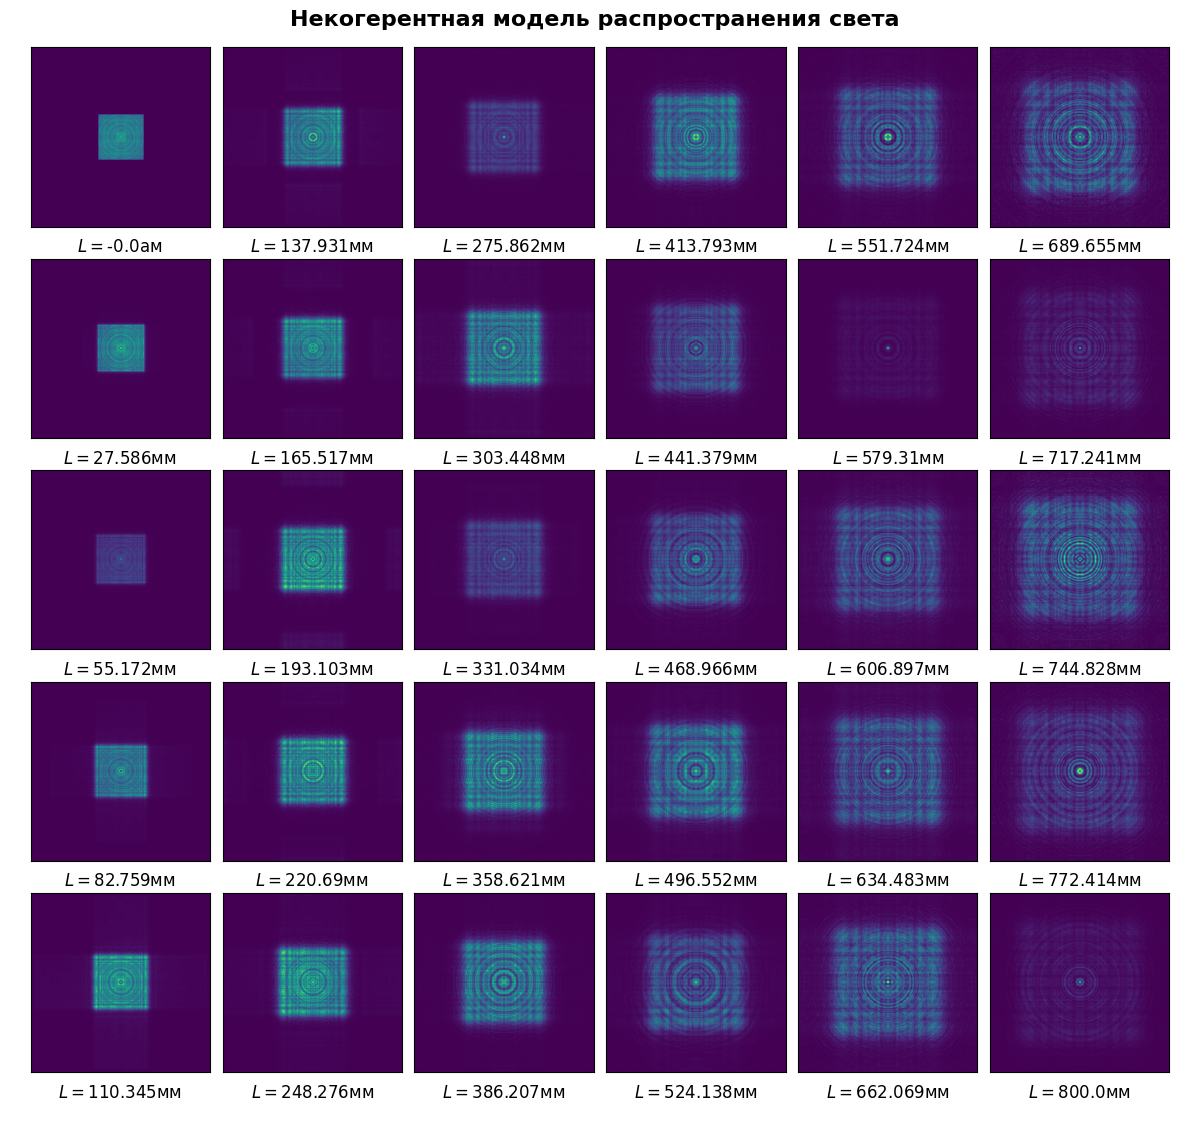

In [14]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Некогерентная модель распространения света")
xy_formatter, xy_unit = engineering.separatedformatter(length, 'м')

for image, distance, (col, row) in zip(incoherent_results, hole_distance_b_array, product(range(cols),range(rows))):   
    axes = plot.axes.add(col,row)
    axes.imshow(image, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(xy_formatter)
    axes.yaxis.set_major_formatter(xy_formatter)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plot.graph.label.x(xy_unit)
    plot.graph.label.y(xy_unit)
    # plot.graph.description(f"{'bm' if distance < hole_distance_a else 'am'}: $L=${engineering(distance,'м',space='')}")
    plot.graph.description(f"$L=${engineering(distance,'м',space='')}")


plot.show()

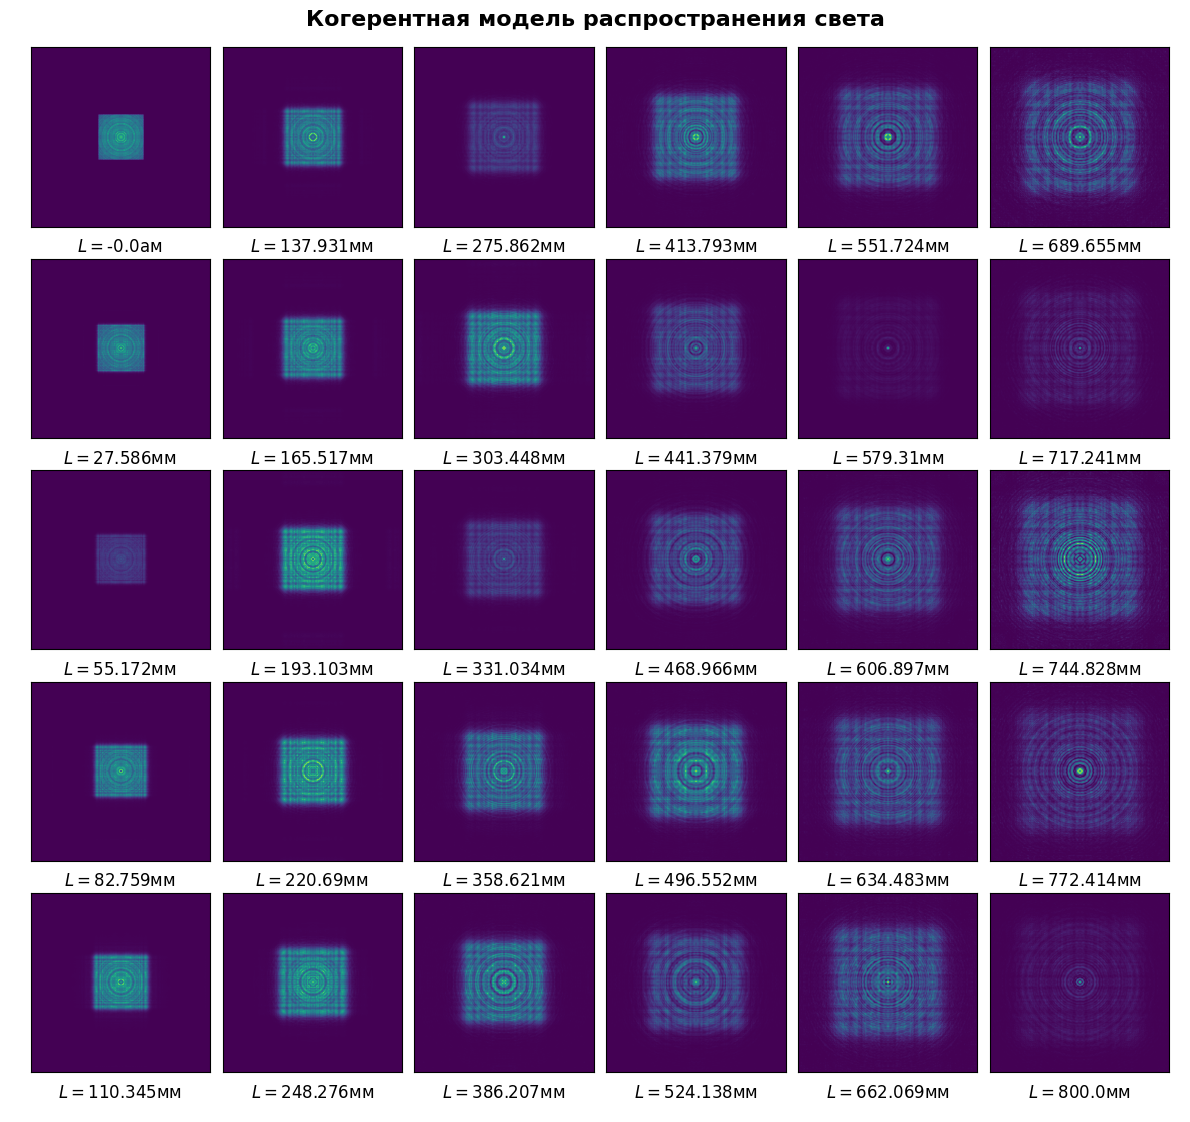

In [15]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Когерентная модель распространения света")
xy_formatter, xy_unit = engineering.separatedformatter(length, 'м')

for image, distance, (col, row) in zip(coherent_results, hole_distance_b_array, product(range(cols),range(rows))):   
    axes = plot.axes.add(col,row)
    axes.imshow(image, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(xy_formatter)
    axes.yaxis.set_major_formatter(xy_formatter)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plot.graph.label.x(xy_unit)
    plot.graph.label.y(xy_unit)
    # plot.graph.description(f"{'bm' if distance < hole_distance_a else 'am'}: $L=${engineering(distance,'м',space='')}")
    plot.graph.description(f"$L=${engineering(distance,'м',space='')}")

plot.show()

# Проверим, что бы происходило, если бы светили сразу квадратом

In [11]:
square_source_field = mask.buffer.clone().detach().unsqueeze(0).unsqueeze(0).to(device)

incoherent_results_ =[]
coherent_results_ = []
with torch.no_grad():
    for distance, (col, row) in tqdm(zip(hole_distance_b_array, product(range(cols),range(rows))), total=cols*rows):
        propagation_b.distance = distance
        coherent_results_.append((propagation_b.forward(square_source_field).squeeze().abs()**2).cpu())
        incoherent_results_.append(decoder.forward(propagation_b.forward(encoder.forward(square_source_field))).abs().squeeze().cpu())
        # coherent_results_.append(propagation_b.forward(square_source_field).squeeze().angle().cpu())
        # incoherent_results_.append(decoder.forward(propagation_b.forward(encoder.forward(square_source_field))).angle().squeeze().cpu())

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.90it/s]


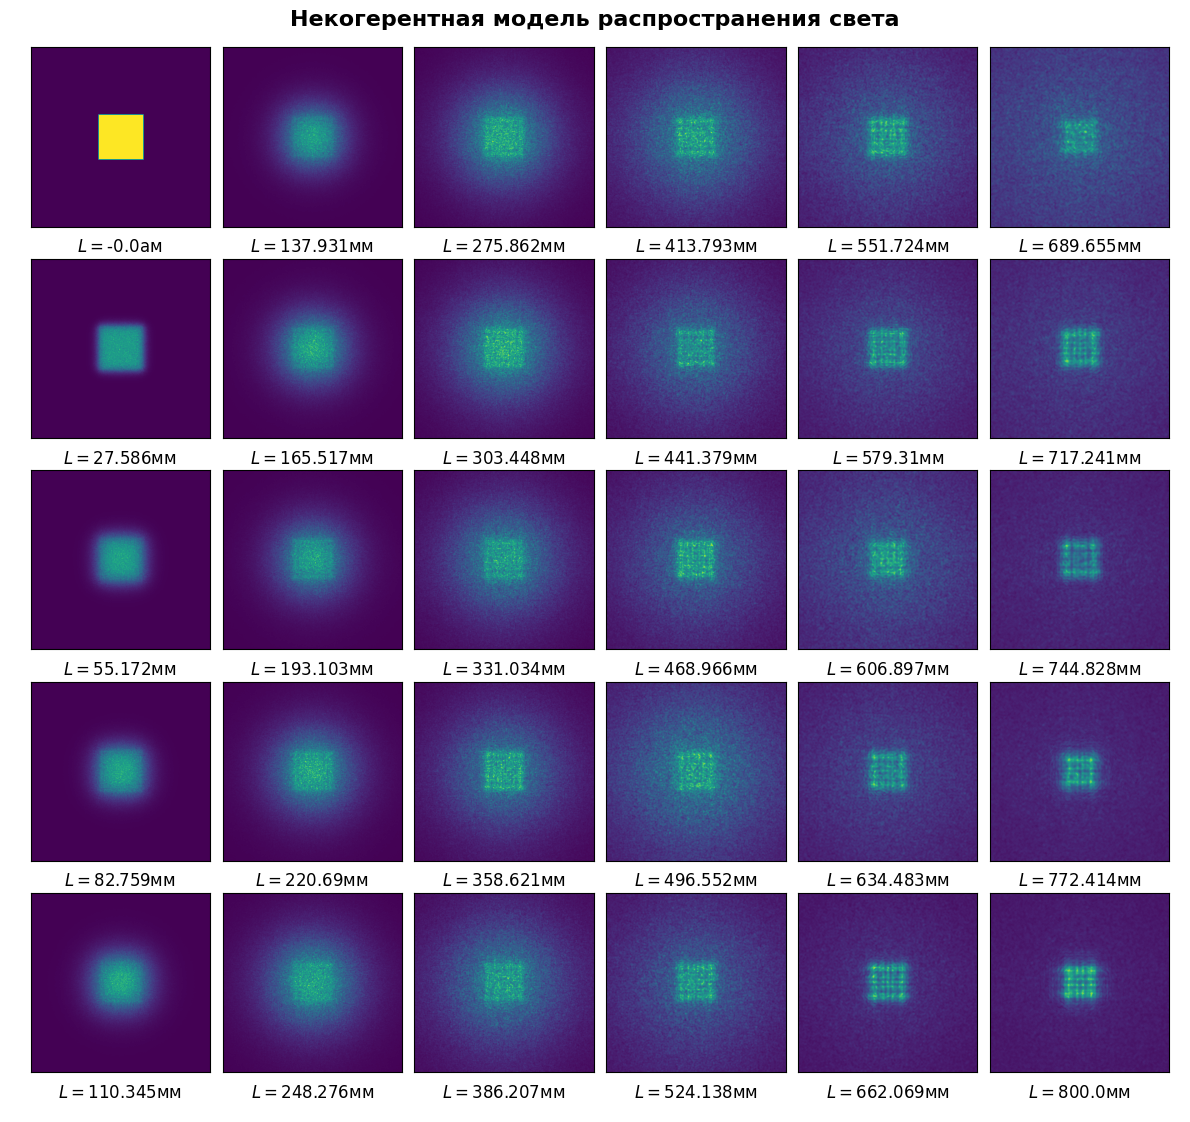

In [16]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Некогерентная модель распространения света")
xy_formatter, xy_unit = engineering.separatedformatter(length, 'м')

for image, distance, (col, row) in zip(incoherent_results_, hole_distance_b_array, product(range(cols),range(rows))):   
    axes = plot.axes.add(col,row)
    axes.imshow(image, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(xy_formatter)
    axes.yaxis.set_major_formatter(xy_formatter)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plot.graph.label.x(xy_unit)
    plot.graph.label.y(xy_unit)
    # plot.graph.description(f"{'bm' if distance < hole_distance_a else 'am'}: $L=${engineering(distance,'м',space='')}")
    plot.graph.description(f"$L=${engineering(distance,'м',space='')}")

plot.show()

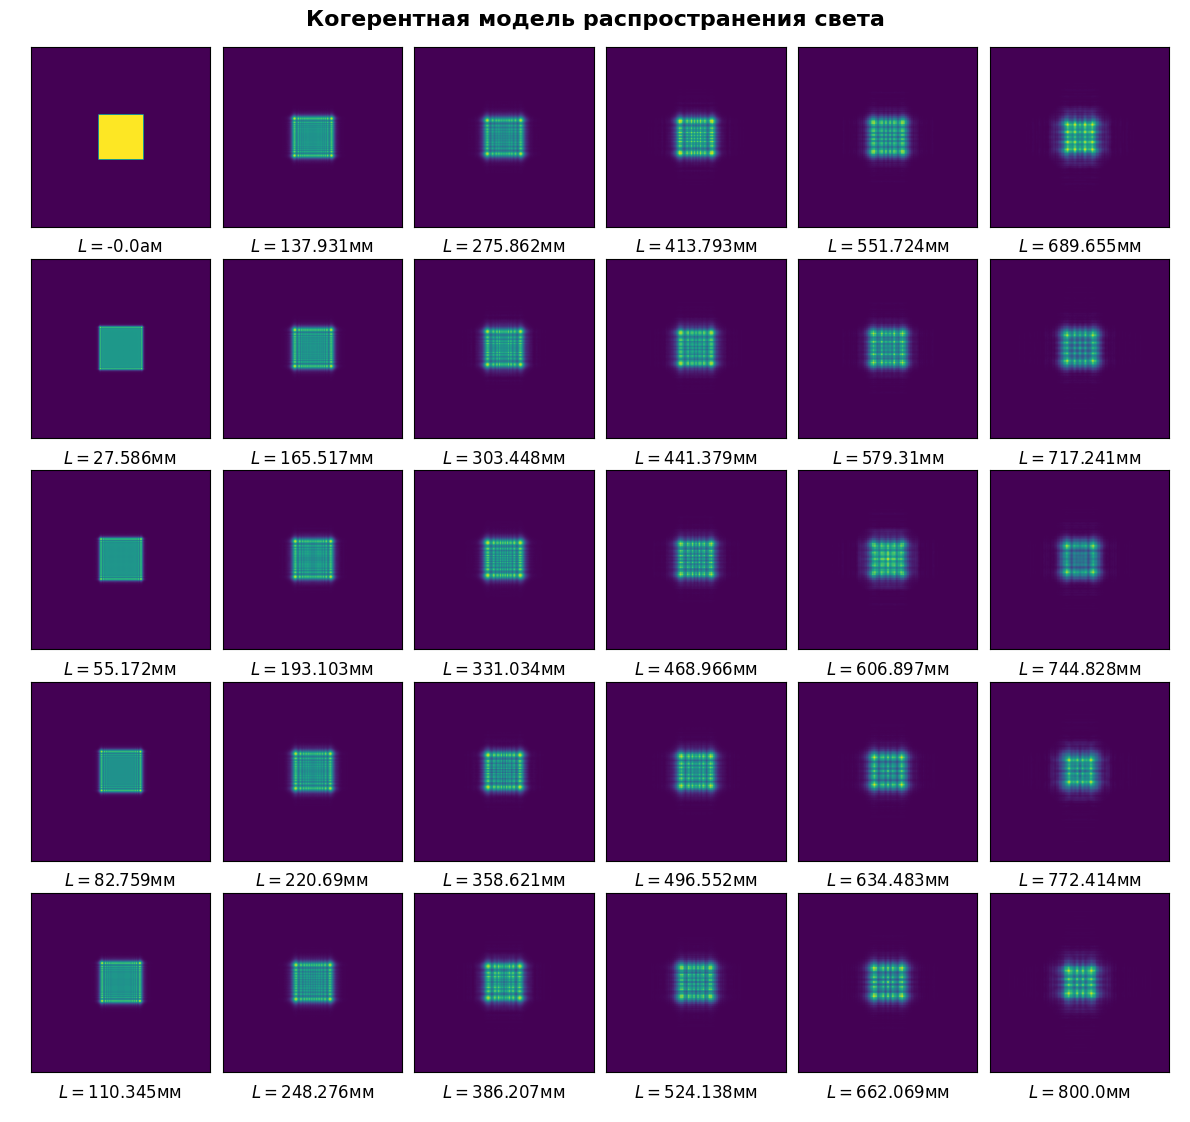

In [17]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title("Когерентная модель распространения света")
xy_formatter, xy_unit = engineering.separatedformatter(length, 'м')

for image, distance, (col, row) in zip(coherent_results_, hole_distance_b_array, product(range(cols),range(rows))):   
    axes = plot.axes.add(col,row)
    axes.imshow(image, aspect='auto', extent=[-length/2,+length/2]*2)
    axes.xaxis.set_major_formatter(xy_formatter)
    axes.yaxis.set_major_formatter(xy_formatter)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plot.graph.label.x(xy_unit)
    plot.graph.label.y(xy_unit)
    # plot.graph.description(f"{'bm' if distance < hole_distance_a else 'am'}: $L=${engineering(distance,'м',space='')}")
    plot.graph.description(f"$L=${engineering(distance,'м',space='')}")

plot.show()